# Create larger data set 
Create the larger data set for each group in for GLM family

## I Data Import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers,activations
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import all the data 
df = pd.read_csv('/content/drive/MyDrive/LD2011_2014.txt',sep = ';', low_memory=False) # load the data
df = df.replace(r",", ".",regex = True) 
df = df.rename(columns = {"Unnamed: 0": "date"})

data = df.drop("date", axis = 1).astype("float")
data["date"] = df.date.apply(lambda x: x.split(' ')[0])
data['date'] = pd.to_datetime(data.date)
data = data.groupby('date').agg('sum').reset_index()

In [5]:
data.tail()

,date,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
1457,2014-12-28,227.157360,2131.578947,151.172893,14327.235772,6776.829268,20122.023810,429.621255,25255.892256,5118.881119,...,28815.132049,3272100.0,220721.518987,257477.272727,8169.491525,552.369807,45914.837577,4405.676127,66135.630499,1.553189e+06
1458,2014-12-29,248.730964,2212.660028,160.729800,14067.073171,7198.780488,22824.404762,550.593556,30286.195286,6697.552448,...,28825.124911,3109100.0,206852.320675,269090.909091,8438.070404,1153.891164,53928.884987,12914.858097,73882.697947,1.806486e+06
1459,2014-12-30,232.233503,2205.547653,165.073849,14290.650407,7189.024390,23880.952381,586.772188,30909.090909,6487.762238,...,28488.222698,2904300.0,204126.582278,263613.636364,10615.384615,892.334699,56334.503951,15996.661102,73950.146628,1.867568e+06
1460,2014-12-31,229.695431,2273.115220,166.811468,14006.097561,7023.170732,23511.904762,690.785755,28700.336700,6211.538462,...,26970.735189,2748800.0,162556.962025,215886.363636,7415.906128,530.134582,50259.877085,13245.409015,70416.422287,1.365892e+06
1461,2015-01-01,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7.135135e+03


## II Clustering

In [6]:
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt

# create a new dataframe without date to do spectral clustering 
df_day = data.copy().T
df_day = df_day.drop('date').fillna(0)
df_day.columns = list(np.arange(1,1463,1))

# spectral clustering
n_clusters = 3
sc = SpectralClustering(n_clusters=n_clusters, affinity = 'nearest_neighbors',random_state=32)
sc.fit(df_day)
labels = sc.labels_ # labels should have 370 data point with value 0, 1, 2

# create a list groups with three arrays inside, representing the index of group 1, 2, 3.
groups = []
for i in range(n_clusters):
    groups.append(np.where(labels == i)[0])

Text(0, 0.5, 'Count')

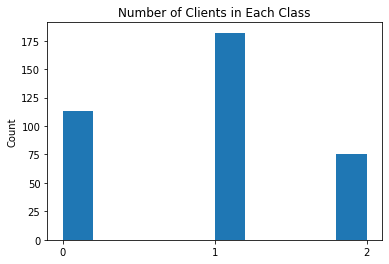

In [7]:
# check number of clients in each class
plt.hist(labels)
plt.xticks(range(n_clusters),[str(i) for i in range(n_clusters)])
plt.title('Number of Clients in Each Class')
plt.ylabel('Count')

In [8]:
# Get the target variable
neigh = sc.affinity_matrix_

groupA=np.where(labels == 0)[0] #170
groupB=np.where(labels == 1)[0] #46
groupC=np.where(labels == 2)[0] #249

# Node with highest degree
targetA = groupA[np.argmax(np.sum(neigh,axis = 1)[groupA])]
targetB = groupB[np.argmax(np.sum(neigh,axis = 1)[groupB])]
targetC = groupC[np.argmax(np.sum(neigh,axis = 1)[groupC])]

## III Time series family
SARIMA and Facebook prophet 

In [11]:
#!pip install pmdarima

In [12]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import pmdarima as pm

from sklearn.metrics import mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def compute_mape(real, predicted):
    mape = mean_absolute_percentage_error(real, predicted)
    return mape


class LinModel:
    
    def __init__(self, alpha=0, l1_ratio=0):
        self.model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        #X_train = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_train)
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        #X_test = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_test)
        preds = self.model.predict(X_test)
        
        return preds

class XGBModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds
    
class RFModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds

    
class RNNModel:
    
    def __init__(self, look_back=400, layer_size=20, epochs=50, verbose=0):
        m = Sequential()
        m.add(LSTM(layer_size, input_shape=(1, look_back)))
        m.add(Dense(1))
        m.compile(loss='mean_squared_error', optimizer='adam')
        
        self.model = m
        self.look_back = look_back
        self.epochs = epochs
        self.verbose = verbose
        
    def fit(self, train):
        
        def create_dataset(data, look_back):
            dataX, dataY = [], []
            for i in range(len(data)-look_back-1):
                a = data[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(data[i + look_back, 0])

            return np.array(dataX), np.array(dataY)
        
        y_train = train['y']
        self.scaler = MinMaxScaler(feature_range = (0, 1)).fit(y_train.values.reshape(-1,1))
        y_train = self.scaler.transform(y_train.values.reshape(-1,1))

        X_train, y_train = create_dataset(y_train, look_back=self.look_back)
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        
        print('training...')
        self.model.fit(X_train, y_train, epochs=self.epochs, verbose=self.verbose)
        self.last_train = X_train[-1,:].reshape((1,1,self.look_back))
    
    ############################################## to complete #############################""
    def predict(self, test):
        # m = self.model
        y_pred = []
        print('predicting...')
        for i in range(len(test)):
            pred = self.model.predict(self.last_train, verbose=0)
            y_pred.append(self.scaler.inverse_transform(pred)[0][0])

            self.last_train = list(self.last_train[0][0][1:])
            self.last_train.append(pred[0][0])
            self.last_train = np.array([[self.last_train]])
        
        return y_pred


class ProphetModel:
    
    def __init__(self, changepoint_prior_scale=None, n_changepoints=None):
        self.model = Prophet()
        
        if changepoint_prior_scale:
            self.model.changepoint_prior_scale = changepoint_prior_scale
        if n_changepoints:
            self.model.n_changepoints = n_changepoints
        
        
        for k in range(1,13):
            self.model.add_regressor(str(k))
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            self.model.add_regressor(day)    

        #self.model.changepoint_prior_scale = i
        #self.model.n_changepoints = j
        
    def fit(self, train):
        self.train = train
        self.model = self.model.fit(train)
    
    def predict(self, test):
        future = self.model.make_future_dataframe(periods=(max(test['ds'])-max(self.train['ds'])).days)
        
        for k in range(1,13):
            future[str(k)] = [1 if future['ds'][l].month==k else 0 for l in range(len(future))]
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            future[day] = [1 if future['ds'][l].strftime('%A')==day else 0 for l in range(len(future))]  
            
        forecast = self.model.predict(future)
        preds = forecast[forecast['ds'].isin(test['ds'])]['yhat']
        
        return preds
    

################################### CAN BE UPGRADED IN SARIMAX #########################################
class SARIMAModel:
    
    def __init__(self, start_p=1, start_q=1, max_p=10, max_q=10, start_P=0, start_Q=0):
        self.start_p, self.start_q, self.max_p, self.max_q, self.start_P, self.start_Q = start_p, start_q, max_p, max_q, start_P, start_Q
        
    def fit(self, train):
        self.model = pm.auto_arima(
            train['y'], 
            start_p=self.start_p,
            start_q=self.start_q,
            max_p=self.max_p,
            max_q=self.max_q,
            m=7,
            start_P=self.start_P,
            start_Q=self.start_Q,
            #trace=True,
            stepwise=False,
            n_jobs=-1)
        
    def predict(self, test):
        m = self.model
        return(m.predict(n_periods=len(test)))

### Model Selection

#### Use one sample to train and use the model to predict others

In [13]:
def train_with_one(target):
  mape = {'sarima':[],'prophet':[]}
  data_A = data.loc[365:]
  data_A = data_A[[f'MT_{target+1:03d}', 'date']]
  data_A["year"] = data_A["date"].apply(lambda x: x.year)
  data_A["month"] = data_A["date"].apply(lambda x: x.month)
  data_A = data_A.join(pd.get_dummies(data_A.month))
  data_A["day"] = data_A["date"].apply(lambda x: x.day)
  data_A["weekday"] = [data_A["date"].iloc[i].strftime('%A') for i in range(len(data_A))]
  # data_A["weekday"] = data_A["date"].apply(lambda x: x.weekday()+1)
  data_A = data_A.join(pd.get_dummies(data_A.weekday))
  data_A = data_A.drop('weekday',axis = 1)
  data_A = data_A.drop('month',axis = 1)
  for j in range(1, 11):
    data_A[f'lagged_{j}'] = data_A[f'MT_{target+1:03d}'].shift(j).fillna(0)
  data_A = data_A.rename(columns={'date':'ds',f'MT_{target+1:03d}':'y'})
  # data_A['t'] = (data_A['ds'] - min(data_A['ds'])).astype('timedelta64[D]').astype(int)
  data_A = data_A.rename(columns={i:str(i) for i in range(1,13)})
  train = data_A[:731]
  test = data_A[731:]

  pro=ProphetModel()
  pro.fit(train)
  preds_pro=pro.predict(test)
  mape['prophet'].append(compute_mape(test['y'], preds_pro))
  sar=SARIMAModel()
  sar.fit(train)
  preds_sar=sar.predict(test)
  mape['sarima'].append(compute_mape(test['y'], preds_sar))
  print(mape)
  return preds_pro, preds_sar
# best_model, mape = model_selection(train,test)

In [14]:
def predict_for_other(target, group):
  preds_pro, preds_sar = train_with_one(target)
  mape = {'sarima':[],'prophet':[]}
  for i in group:
    data_A = data.loc[365:]
    data_A = data_A[[f'MT_{i+1:03d}', 'date']]
    data_A = data_A.rename(columns={'date':'ds',f'MT_{i+1:03d}':'y'})
    train = data_A[:731]
    test = data_A[731:]
    mape['prophet'].append(compute_mape(test['y'], preds_pro))
    mape['sarima'].append(compute_mape(test['y'], preds_sar))
  return mape

In [16]:
print('GroupA')
mapeA = predict_for_other(targetA, groupA)
print(np.mean(mapeA['prophet']))
print(np.mean(mapeA['sarima']))
print(np.median(mapeA['prophet']))
print(np.median(mapeA['sarima']))
print('GroupB')
mapeB = predict_for_other(targetB, groupB)
print(np.mean(mapeB['prophet']))
print(np.mean(mapeB['sarima']))
print(np.median(mapeB['prophet']))
print(np.median(mapeB['sarima']))
print('GroupC')
mapeC = predict_for_other(targetC, groupC)
print(np.mean(mapeC['prophet']))
print(np.mean(mapeC['sarima']))
print(np.median(mapeC['prophet']))
print(np.median(mapeC['sarima']))

GroupA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/mc36v746.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/7ua6k3hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42569', 'data', 'file=/tmp/tmp755dy_du/mc36v746.json', 'init=/tmp/tmp755dy_du/7ua6k3hj.json', 'output', 'file=/tmp/tmp755dy_du/prophet_model8k1duct_/prophet_model-20221216210437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'sarima': [0.574854903255523], 'prophet': [0.7644016743931447]}
1.0005821542947145e+18
8.764668633570787e+17
0.8638421745316898
0.8561102381339503
GroupB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/83wdjim6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/6h_wol4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95159', 'data', 'file=/tmp/tmp755dy_du/83wdjim6.json', 'init=/tmp/tmp755dy_du/6h_wol4c.json', 'output', 'file=/tmp/tmp755dy_du/prophet_model62e5cen_/prophet_model-20221216210610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'sarima': [0.7658321275925797], 'prophet': [0.34401762249406276]}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/o5fb_hfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/t1y6a3gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2899', 'data', 'file=/tmp/tmp755dy_du/o5fb_hfu.json', 'init=/tmp/tmp755dy_du/t1y6a3gf.json', 'output', 'file=/tmp/tmp755dy_du/prophet_modeloaeml487/prophet_model-20221216210813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1.5526482979783318e+17
1.9889776026922346e+17
0.8925913013780504
0.8483761630479685
GroupC


21:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'sarima': [0.5021632207811748], 'prophet': [0.48029664875620526]}
2.3070196719003108e+16
2.241703862213894e+16
0.6807789625685463
0.7546401482096357


#### Create model for each person
This will train 370 differnt models 

In [17]:
class SARIMAModel:
    
    def __init__(self, start_p=1, start_q=1, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=3, max_Q=3):
        self.start_p, self.start_q, self.max_p, self.max_q, self.start_P, self.start_Q, self.max_P, self.max_Q = start_p, start_q, max_p, max_q, start_P, start_Q, max_P, max_Q
        
    def fit(self, train):
        self.model = pm.auto_arima(
            train['y'], 
            start_p=self.start_p,
            start_q=self.start_q,
            max_p=self.max_p,
            max_q=self.max_q,
            # d = 1,
            # D = 1,
            m=1,
            # trend = True,
            start_P=self.start_P,
            start_Q=self.start_Q,
            max_P=self.max_P, 
            max_Q=self.max_Q,
            #trace=True,
            stepwise=False,
            n_jobs=-1)
        
    def predict(self, test):
        m = self.model
        return(m.predict(n_periods=len(test)))

In [18]:
mape = [{'sarima':[],'prophet':[]} for i in range(n_clusters)]
k = 0
for d in [groupA,groupB,groupC]:
  for i in d:

    data_A = data.loc[365:]
    data_A = data_A[[f'MT_{i+1:03d}', 'date']]
    data_A["year"] = data_A["date"].apply(lambda x: x.year)
    data_A["month"] = data_A["date"].apply(lambda x: x.month)
    data_A = data_A.join(pd.get_dummies(data_A.month))
    data_A["day"] = data_A["date"].apply(lambda x: x.day)
    data_A["weekday"] = [data_A["date"].iloc[i].strftime('%A') for i in range(len(data_A))]
    # data_A["weekday"] = data_A["date"].apply(lambda x: x.weekday()+1)
    data_A = data_A.join(pd.get_dummies(data_A.weekday))
    data_A = data_A.drop('weekday',axis = 1)
    data_A = data_A.drop('month',axis = 1)
    for j in range(1, 21):
      data_A[f'lagged_{j}'] = data_A[f'MT_{i+1:03d}'].shift(i).fillna(0)
    
    data_A = data_A.rename(columns={'date':'ds',f'MT_{i+1:03d}':'y'})
    # data_A['t'] = (data_A['ds'] - min(data_A['ds'])).astype('timedelta64[D]').astype(int)
    data_A = data_A.rename(columns={i:str(i) for i in range(1,13)})
    train = data_A[:731]
    test = data_A[731:]
    
    m=ProphetModel()
    m.fit(train)
    preds=m.predict(test)
    mape[k]['prophet'].append(compute_mape(test['y'], preds))
  k+=1
  # m=SARIMAModel()
  # m.fit(train)
  # preds=m.predict(test)
  # mape['sarima'].append(compute_mape(test['y'], preds))
  # best_model, mape = model_selection(train,test)
  # break

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/broy4qvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755dy_du/r1bact6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19717', 'data', 'file=/tmp/tmp755dy_du/broy4qvl.json', 'init=/tmp/tmp755dy_du/r1bact6o.json', 'output', 'file=/tmp/tmp755dy_du/prophet_modelkv6v3ovh/prophet_model-20221216211141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp755

In [19]:
print('Prophet')
for i in range(len(mape)):
  print(np.median(mape[i]['prophet']))

Prophet
0.5748251371861669
0.6197899357969587
0.5655294510689803


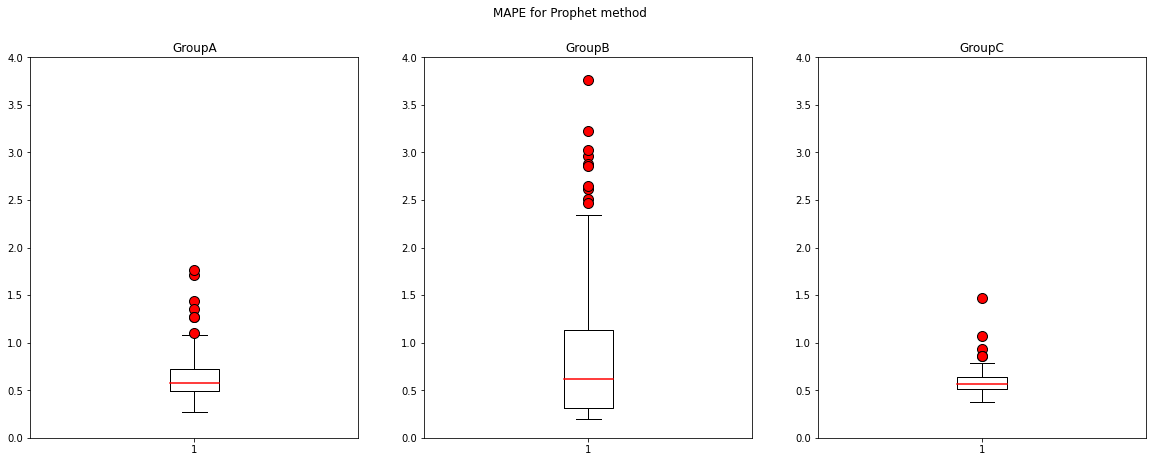

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('MAPE for Prophet method')
_ = ax1.boxplot(mape[0]['prophet'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
_ = ax2.boxplot(mape[1]['prophet'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
_ = ax3.boxplot(mape[2]['prophet'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
ax1.title.set_text('GroupA')
ax2.title.set_text('GroupB')
ax3.title.set_text('GroupC')
ax1.set_ylim([0, 4])
ax2.set_ylim([0, 4])
ax3.set_ylim([0, 4]);

In [21]:
# mape = [{'sarima':[],'prophet':[]} for i in range(n_clusters)]
k = 0
for d in [groupA,groupB,groupC]:
  for i in d:

    data_A = data.loc[365:]
    data_A = data_A[[f'MT_{i+1:03d}', 'date']]
    data_A["year"] = data_A["date"].apply(lambda x: x.year)
    data_A["month"] = data_A["date"].apply(lambda x: x.month)
    data_A = data_A.join(pd.get_dummies(data_A.month))
    data_A["day"] = data_A["date"].apply(lambda x: x.day)
    data_A["weekday"] = [data_A["date"].iloc[i].strftime('%A') for i in range(len(data_A))]
    # data_A["weekday"] = data_A["date"].apply(lambda x: x.weekday()+1)
    data_A = data_A.join(pd.get_dummies(data_A.weekday))
    data_A = data_A.drop('weekday',axis = 1)
    data_A = data_A.drop('month',axis = 1)
    for j in range(1, 21):
      data_A[f'lagged_{j}'] = data_A[f'MT_{i+1:03d}'].shift(i).fillna(0)
    
    data_A = data_A.rename(columns={'date':'ds',f'MT_{i+1:03d}':'y'})
    # data_A['t'] = (data_A['ds'] - min(data_A['ds'])).astype('timedelta64[D]').astype(int)
    data_A = data_A.rename(columns={i:str(i) for i in range(1,13)})
    train = data_A[:731]
    test = data_A[731:]
    m=SARIMAModel()
    m.fit(train)
    preds=m.predict(test)
    mape[k]['sarima'].append(compute_mape(test['y'], preds))
  k+=1

  # best_model, mape = model_selection(train,test)
  # break

In [ ]:
print('Sarima')
for i in range(len(mape)):
  print(np.median(mape[i]['sarima']))

Sarima
0.6700421781368278
0.6879375153145252
0.6682677050151525


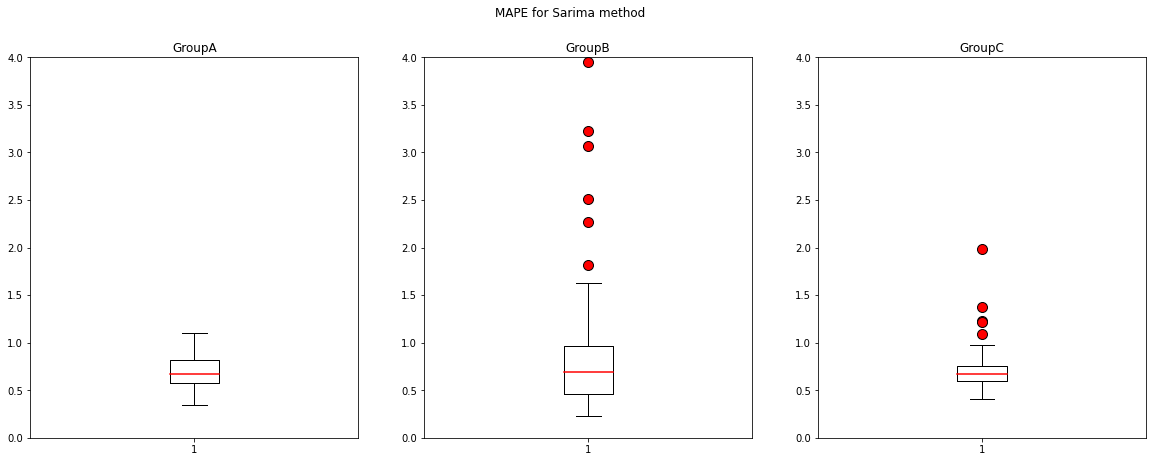

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('MAPE for Sarima method')
_ = ax1.boxplot(mape[0]['sarima'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
_ = ax2.boxplot(mape[1]['sarima'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
_ = ax3.boxplot(mape[2]['sarima'],medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10})
ax1.title.set_text('GroupA')
ax2.title.set_text('GroupB')
ax3.title.set_text('GroupC')
ax1.set_ylim([0, 4])
ax2.set_ylim([0, 4])
ax3.set_ylim([0, 4]);

### LSTM

In [ ]:
import statsmodels.api as sm
# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten, Input, BatchNormalization
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [ ]:

# Number of lags (hours back) to use for models
lag = 30

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 40

# Batch size 
batch_size = 200

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [ ]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    # print(ts.iloc[:,(i + lag):(i + lag + n_ahead)])
    # Creating placeholder lists
    X, Y = [], []

    if n_features - lag <= 0:
        X.append(ts)
    else:
        for i in range(n_features - lag - n_ahead):
            
            Y.append(ts.iloc[:,(i + lag):(i + lag + n_ahead)])
            X.append(ts.iloc[:,i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], lag))
    Y = np.reshape(Y, (Y.shape[0], Y.shape[1],1))
    return X, Y

In [ ]:
data.iloc[366:]['MT_043']

366     118090.909091
367     113250.000000
368     112659.090909
369     113000.000000
370     108022.727273
            ...      
1457    112522.727273
1458    119363.636364
1459    128977.272727
1460    132113.636364
1461      1227.272727
Name: MT_043, Length: 1096, dtype: float64

In [ ]:
data_A = df_day.iloc[:,365:]
data_A = data_A.iloc[groupA].iloc[:-1]
# data_A["year"] = data_A["date"].apply(lambda x: x.year)
# data_A["month"] = data_A["date"].apply(lambda x: x.month)
# data_A = data_A.join(pd.get_dummies(data_A.month))
# data_A["day"] = data_A["date"].apply(lambda x: x.day)
# data_A["weekday"] = [data_A["date"].iloc[i].strftime('%A') for i in range(len(data_A))]
# # data_A["weekday"] = data_A["date"].apply(lambda x: x.weekday()+1)
# data_A = data_A.join(pd.get_dummies(data_A.weekday))
# data_A = data_A.drop('weekday',axis = 1)
# data_A = data_A.drop('month',axis = 1)
# for j in range(1, 21):
#   data_A[f'lagged_{j}'] = data_A[f'MT_{0+1:03d}'].shift(0).fillna(0)

# data_A = data_A.rename(columns={'date':'ds',f'MT_{0+1:03d}':'y'})
# # data_A['t'] = (data_A['ds'] - min(data_A['ds'])).astype('timedelta64[D]').astype(int)
# data_A = data_A.rename(columns={i:str(i) for i in range(1,13)})
# train = data_A[:731]
# test = data_A[731:]

In [ ]:
X, Y = create_X_Y(data_A, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [ ]:
Xtrain.shape

(959, 112, 30)

In [ ]:
Ytrain.shape

(959, 112, 1)

In [ ]:
class NNMultistepModel_tp():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        # batch = BatchNormalization()
        # lstm_layer = LSTM(n_layer, activation='relu')(batch)
        
        # # lstm_layer = LSTM(n_layer, activation='relu')(lstm_layer)
        # x = Dense(n_outputs)(lstm_layer)
        model = Sequential()
        model.add(Input(shape=(n_lag, n_ft)))
        # model.add(BatchNormalization())
        model.add(LSTM(n_layer, activation='sigmoid'))
        model.add(BatchNormalization())
        model.add(Dense(n_outputs))
        # self.model = Model(inputs=lstm_input, outputs=x)
        self.model = model
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsolutePercentageError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                # callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                # callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

model = NNMultistepModel_tp(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=Xtrain.shape[1],
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [ ]:
history = model.train()

Epoch 1/40
5/5 [==============================] - 2s 245ms/step - loss: 9118029.0000 - val_loss: 2912061.2500
Epoch 2/40
5/5 [==============================] - 1s 186ms/step - loss: 9071391.0000 - val_loss: 2879311.2500
Epoch 3/40
5/5 [==============================] - 1s 167ms/step - loss: 8970353.0000 - val_loss: 2311517.5000
Epoch 4/40
5/5 [==============================] - 1s 170ms/step - loss: 8207473.5000 - val_loss: 2092267.8750
Epoch 5/40
5/5 [==============================] - 1s 182ms/step - loss: 7787391.5000 - val_loss: 2072373.3750
Epoch 6/40
5/5 [==============================] - 1s 173ms/step - loss: 7479251.5000 - val_loss: 2096996.0000
Epoch 7/40
5/5 [==============================] - 1s 174ms/step - loss: 7055835.5000 - val_loss: 2239413.2500
Epoch 8/40
5/5 [==============================] - 1s 180ms/step - loss: 7072357.0000 - val_loss: 2621661.0000
Epoch 9/40
5/5 [==============================] - 1s 159ms/step - loss: 7338058.5000 - val_loss: 2971702.5000
Epoch 10/4

In [ ]:
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

4/4 [==============================] - 0s 47ms/step


## IV GLM
Try GLM on the three different group

### Preprocessing: Create the larger data set for each group

#### (a) create combined larger data set

In [ ]:
# create data_agg
data_agg = df.drop("date", axis = 1).astype("float")
data_agg["date"] = df.date.apply(lambda x: x.split(' ')[0])
data_agg['date'] = pd.to_datetime(data_agg.date)
data_agg = data_agg.groupby('date').agg('sum').reset_index()
print(data_agg.shape) # should be (1462, 371)

(1462, 371)


In [ ]:
## create the large data set for one client
'''
    create_large_data(data_agg, client)
        subset the large data for a client about his/her daily electronic usage.
    
    Input:
        client: the index of the client; integer range from 1 to 370.
        df: an aggregated data of daily electronic usage for all client; default to data_agg.
    
    output:
        a dataframe of the daily electronic usage of that client. 
'''
def create_large_data(client, df = data_agg):
    # 0. check client
    client += 1
    client_name = ''
    if (client < 1 or client > 370):
        raise Exception("Client has to be an integer between 1 and 370.")
    elif (client <= 9): # client is one digit
        client_name = f'MT_00{client}'
    elif (client <= 99): # client is two digits
        client_name = f'MT_0{client}'
    else: # client is three digits
        client_name = f'MT_{client}'
    
    # 1. get the daily usage data for the client and remove 0 and negatives
    client_data = df.loc[df[client_name] > 0,[client_name, 'date']]
    client_data.columns = ["usage", "date"] # change the column names to usage
    
    # 2. add exogenuous variables: client, month, weekday, time
    client_data["client"] = client_name
    #client_data["year"] = client_data.date.dt.year
    client_data["month"] = client_data.date.dt.month
    client_data["weekday"] = client_data.date.dt.strftime('%A')
    client_data["time"] = (client_data.date - min(client_data.date)).astype('timedelta64[D]').astype(int) \
    
    return client_data

In [ ]:
## create the large data set for one group
'''
    combine_within_group(group, categorical_col)
        create a combined large data for every client in the group.
    
    Input:
        group: a list of integers which represets the clients in a group.
        categorical_col: a list of categorical variables; default as ['month', 'weekday'].
    
    output:
        a combined dataframe of the daily electronic usage of that group. 
'''
def combine_within_group(group, categorical_col = ['month', 'weekday']):
    # create the concatenated data frame
    frames = [] # frames is an array to store a data frame of each client
    for client in group:
        frames.append(create_large_data(client))
    result = pd.concat(frames)
    # create 
    one_enc = OneHotEncoder(handle_unknown='ignore')
    one_hot_map = one_enc.fit_transform(result[categorical_col])
    one_hot_map_df = pd.DataFrame(one_hot_map.toarray(), columns = one_enc.get_feature_names_out()).astype(int)
    result = result.join(one_hot_map_df)
    result.drop(categorical_col, axis = 1, inplace = True)
    
    return(result)

#### (b) split data

In [ ]:
## create the data in to training and testing
'''
    split_large_data(df, split_date)
        split the date into training and testing with a default split date of 2014-01-01.
    
    Input:
        df: the combined large data of a group.
        split_date: the date splits training and testing; default as "2014-01-01".
    
    output:
        a combined dataframe of the daily electronic usage of that group. 
'''
def split_large_data(df, split_date = "2014-01-01" ):
    # check if df has the column "date"
    if ("date" not in df.columns):
        raise Exception("Missing column: date") 
    training = df[df.date < split_date]
    testing = df[df.date >= split_date]
    return training, testing

In [ ]:
# create the large date set for the three groups
group_A = combine_within_group(groups[0])
group_B = combine_within_group(groups[1])
group_C = combine_within_group(groups[2])

group_A_train, group_A_test = split_large_data(group_A)
group_B_train, group_B_test = split_large_data(group_B)
group_C_train, group_C_test = split_large_data(group_C)

In [ ]:
# check the data set
print(group_A_train.shape)
print(group_A_test.shape)
print(group_B_train.shape)
print(group_B_test.shape)
print(group_C_train.shape)
print(group_C_test.shape)

(22114, 23)
(9150, 23)
(249128, 23)
(112282, 23)
(29835, 23)
(12797, 23)


In [ ]:
group_A_train_use = group_A_train.drop(columns = ['date', 'client'])
group_B_train_use = group_B_train.drop(columns = ['date', 'client'])
group_C_train_use = group_C_train.drop(columns = ['date', 'client'])
group_A_test_use = group_A_test.drop(columns = ['date', 'client'])
group_B_test_use = group_B_test.drop(columns = ['date', 'client'])
group_C_test_use = group_C_test.drop(columns = ['date', 'client'])

### MODELS CLASS

In [ ]:
from pandas.io.formats.format import set_eng_float_format
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
#import pmdarima as pm

from sklearn.metrics import mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def compute_mape(real, predicted):
    mape = mean_absolute_percentage_error(real, predicted)
    return mape


class LinModel:
    
    def __init__(self, alpha=0, l1_ratio=0):
        self.model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
    def fit(self, train):
        X_train, y_train = train.drop(['usage'], axis=1), train['usage']
        #X_train = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_train)
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['usage'], axis=1)
        #X_test = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_test)
        preds = self.model.predict(X_test)
        
        return preds

class XGBModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['usage'], axis=1), train['usage']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['usage'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds
    
class RFModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['usage'], axis=1), train['usage']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['usage'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds


class RNNModel:
    
    def __init__(self, look_back=400, layer_size=20, epochs=50, verbose=0):
        m = Sequential()
        m.add(LSTM(layer_size, input_shape=(1, look_back)))
        m.add(Dense(1))
        m.compile(loss='mean_squared_error', optimizer='adam')
        
        self.model = m
        self.look_back = look_back
        self.epochs = epochs
        self.verbose = verbose
        
    def fit(self, train):
        
        def create_dataset(data, look_back):
            dataX, dataY = [], []
            for i in range(len(data)-look_back-1):
                a = data[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(data[i + look_back, 0])

            return np.array(dataX), np.array(dataY)
        
        y_train = train['usage']
        self.scaler = MinMaxScaler(feature_range = (0, 1)).fit(y_train.values.reshape(-1,1))
        y_train = self.scaler.transform(y_train.values.reshape(-1,1))

        X_train, y_train = create_dataset(y_train, look_back=self.look_back)
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        
        print('training...')
        self.model.fit(X_train, y_train, epochs=self.epochs, verbose=self.verbose)
        self.last_train = X_train[-1,:].reshape((1,1,self.look_back))
    
    def predict(self, test):
        
        y_pred = []
        print('predicting...')
        for i in range(len(test)):
            pred = m.model.predict(m.last_train, verbose=0)
            y_pred.append(self.scaler.inverse_transform(pred)[0][0])

            m.last_train = list(m.last_train[0][0][1:])
            m.last_train.append(pred[0][0])
            m.last_train = np.array([[m.last_train]])


class ProphetModel:
    
    def __init__(self, changepoint_prior_scale=None, n_changepoints=None):
        self.model = Prophet()
        
        if changepoint_prior_scale:
            self.model.changepoint_prior_scale = changepoint_prior_scale
        if n_changepoints:
            self.model.n_changepoints = n_changepoints
        
        
        for k in range(1,13):
            self.model.add_regressor(str(k))
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            self.model.add_regressor(day)    

        #self.model.changepoint_prior_scale = i
        #self.model.n_changepoints = j
        
    def fit(self, train):
        self.train = train
        self.model = self.model.fit(train)
    
    def predict(self, test):
        future = self.model.make_future_dataframe(periods=(max(test['ds'])-max(self.train['ds'])).days)
        
        for k in range(1,13):
            future[str(k)] = [1 if future['ds'][l].month==k else 0 for l in range(len(future))]
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            future[day] = [1 if future['ds'][l].strftime('%A')==day else 0 for l in range(len(future))]  
            
        forecast = self.model.predict(future)
        preds = forecast[forecast['ds'].isin(test['ds'])]['yhat']
        
        return preds
    

# ################################### CAN BE UPGRADED IN SARIMAX #########################################
# class SARIMAModel:
    
#     def __init__(self, start_p=1, start_q=1, max_p=10, max_q=10, start_P=0, start_Q=0):
#         self.start_p, self.start_q, self.max_p, self.max_q, self.start_P, self.start_Q = start_p, start_q, max_p, max_q, start_P, start_Q
        
#     def fit(self, train):
#         self.model = pm.auto_arima(
#             train['y'], 
#             start_p=self.start_p,
#             start_q=self.start_q,
#             max_p=self.max_p,
#             max_q=self.max_q,
#             m=7,
#             start_P=self.start_P,
#             start_Q=self.start_Q,
#             #trace=True,
#             stepwise=False,
#             n_jobs=-1)
        
#     def predict(self, test):
#         m = self.model
#         return(m.predict(n_periods=len(test)))

In [ ]:
# function: compute mape for every one
import statistics
from statistics import median, mean
import seaborn as sns

def compute_group_mape(test, model): 
  clients  = np.unique(test.client)
  mape = []  
  for c in clients:
    temp_test = test[test.client == c]
    temp_test.drop(columns = ['date', 'client'], inplace = True)
    temp_pred = model.predict(temp_test)
    mape.append(compute_mape(temp_test["usage"], temp_pred))
  result = pd.DataFrame({"clients" : clients, "mape": mape,})
  return(result)

def print_group_mape(tests, models, report_median = True, boxplot = True):
  if (len(tests) != len(models)):
    raise Exception("Tests and models don't have same size.") 
  
  n = len(tests)
  frames = []
  for i in range(n):
    temp = compute_group_mape(tests[i], models[i])
    temp['group'] = f"group_{i}"
    frames.append(temp)
  result = pd.concat(frames)

  if (report_median):
    print(result[['mape', 'group']].groupby('group').agg('median'))
  if (boxplot):
    sns.boxplot(data = result, x = 'mape', y = 'group', showfliers = False)

  return result 

### Linear Model

In [ ]:
linear_mapes = dict()

linear_modelA = LinModel()
linear_modelA.fit(group_A_train_use)
linear_modelA_pred = linear_modelA.predict(group_A_test_use)
linear_mapeA = compute_mape(group_A_test_use['usage'], linear_modelA_pred)
linear_mapes['groupA'] = linear_mapeA

linear_modelB = LinModel()
linear_modelB.fit(group_B_train_use)
linear_modelB_pred = linear_modelB.predict(group_B_test_use)
linear_mapeB = compute_mape(group_B_test_use['usage'], linear_modelB_pred)
linear_mapes['groupB'] = linear_mapeB

linear_modelC = LinModel()
linear_modelC.fit(group_C_train_use)
linear_modelC_pred = linear_modelC.predict(group_C_test_use)
linear_mapeC = compute_mape(group_C_test_use['usage'], linear_modelC_pred)
linear_mapes['groupC'] = linear_mapeC

linear_mapes

{'groupA': 15.03645003301081,
 'groupB': 23.988822233787754,
 'groupC': 13.145388461305346}

             mape
group            
group_0  3.011896
group_1  6.268369
group_2  7.225691


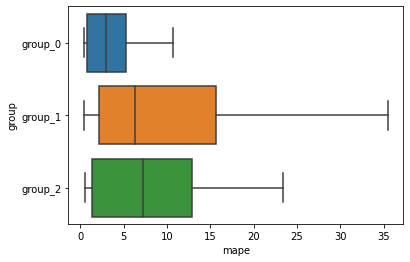

In [ ]:
test = print_group_mape(tests = [group_A_test, group_B_test, group_C_test], 
                        models = [linear_modelA, linear_modelB, linear_modelC])

### XGBoost

In [ ]:
xgb_mapes = dict()

xgb_modelA = XGBModel()
xgb_modelA.fit(group_A_train_use)
xgb_modelA_pred = xgb_modelA.predict(group_A_test_use)
xgb_mapeA = compute_mape(group_A_test_use['usage'], xgb_modelA_pred)
xgb_mapes['groupA'] = xgb_mapeA

xgb_modelB = XGBModel()
xgb_modelB.fit(group_B_train_use)
xgb_modelB_pred = xgb_modelB.predict(group_B_test_use)
xgb_mapeB = compute_mape(group_B_test_use['usage'], xgb_modelB_pred)
xgb_mapes['groupB'] = xgb_mapeB

xgb_modelC = XGBModel()
xgb_modelC.fit(group_C_train_use)
xgb_modelC_pred = xgb_modelC.predict(group_C_test_use)
xgb_mapeC = compute_mape(group_C_test_use['usage'], xgb_modelC_pred)
xgb_mapes['groupC'] = xgb_mapeC

xgb_mapes

[17:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'groupA': 14.218723570888786,
 'groupB': 23.844157656832508,
 'groupC': 12.636704674585715}

             mape
group            
group_0  2.837069
group_1  6.493873
group_2  6.600452


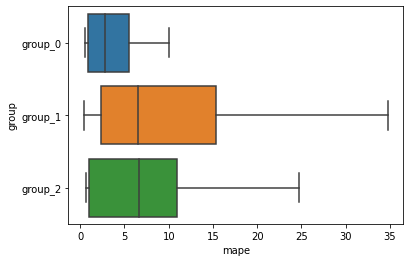

In [ ]:
# print the median mape and the box plot of mapes
test = print_group_mape(tests = [group_A_test, group_B_test, group_C_test], 
                        models = [xgb_modelA, xgb_modelB, xgb_modelC])

### Random Forest

In [ ]:
rf_mapes = dict()

rf_modelA = RFModel()
rf_modelA.fit(group_A_train_use)
rf_modelA_pred = rf_modelA.predict(group_A_test_use)
rf_mapeA = compute_mape(group_A_test_use['usage'], rf_modelA_pred)
rf_mapes['groupA'] = rf_mapeA

rf_modelB = RFModel()
rf_modelB.fit(group_B_train_use)
rf_modelB_pred = rf_modelB.predict(group_B_test_use)
rf_mapeB = compute_mape(group_B_test_use['usage'], rf_modelB_pred)
rf_mapes['groupB'] = rf_mapeB

rf_modelC = RFModel()
rf_modelC.fit(group_C_train_use)
rf_modelC_pred = rf_modelC.predict(group_C_test_use)
rf_mapeC = compute_mape(group_C_test_use['usage'], rf_modelC_pred)
rf_mapes['groupC'] = rf_mapeC

rf_mapes

{'groupA': 14.51331116277944,
 'groupB': 25.05614242822082,
 'groupC': 13.623896155631275}

             mape
group            
group_0  2.895784
group_1  7.247562
group_2  7.517271


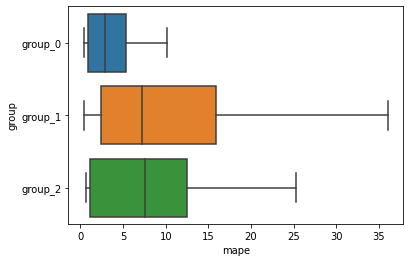

In [ ]:
# print the median mape and the box plot of mapes
test = print_group_mape(tests = [group_A_test, group_B_test, group_C_test], 
                        models = [rf_modelA, rf_modelB, rf_modelC])

## V RNN - LSTM

In [ ]:
rnn_mapes = dict()

m = RNNModel()
m.fit(group_A_train_use)
rnn_modelA_pred = m.predict(group_A_test_use)
rnn_mapeA = compute_mape(group_A_test_use['usage'], rnn_modelA_pred)
rnn_mapes['groupA'] = rnn_mapeA

m = RNNModel()
m.fit(group_B_train_use)
rnn_modelB_pred = m.predict(group_B_test_use)
rnn_mapeB = compute_mape(group_B_test_use['usage'], rnn_modelB_pred)
rnn_mapes['groupB'] = rnn_mapeB

m = RNNModel()
m.fit(group_C_train_use)
rnn_modelC_pred = m.predict(group_C_test_use)
rnn_mapeC = compute_mape(group_C_test_use['usage'], rnn_modelC_pred)
rnn_mapes['groupC'] = rnn_mapeC

rnn_mapes

training...
predicting...


ValueError: ignored